**1. Experiment plan (must-have before launch)**
- Objective / Primary metric: Average Order Value (AOV) per order (continuous).
- Unit of randomization: `order` or `user` (pick one; prefer user if the same user may place multiple orders and you want independent users).
- Hypotheses:
    - *Null* $𝐻_0: \mu_A = \mu_B$ (no difference in mean AOV)
    - *Alternative* $𝐻_1: \mu_A \ne \mu_B$ (two-sided) — or use one-sided if you only care whether B > A.
- Alpha (type I error): 0.05 (default).
- Power (1−β): 0.8 (default).
- Minimum Detectable Effect (MDE): choose the smallest meaningful lift in dollars or percent (e.g., $2 or 4%).
- Pre-registration: register metric, sample-size / stopping rule, segmentation plan, and primary analysis before peeking.
- Duration & stopping rule: fixed-sample preferred. If doing sequential monitoring, use alpha-spending or Bayesian methods. Don’t peek repeatedly without correction.

**2. Instrumentation & data logging (production)**
- Log every user’s assignment: user_id, bucket (A/B), timestamp, exposure_flag.
- Log outcome per unit: order_id, user_id, order_value, order_time, channel, device, segment_vars.
- Log events to an immutable store (S3, data warehouse). Avoid ad-hoc aggregation at the client side.
- Dedup keys: unique order_id. Also, track the first exposure and make sure there is no cross-contamination.
- Ensure data privacy & opt-outs (GDPR/CCPA) are respected.

**3. Sample size calculation**
- Estimate baseline mean AOV mu_A and std dev sigma from historical data.
- Decide `delta = MDE` (**M**inimum **D**etectable **E**ffect: absolute dollars) you want to detect.
- Compute Cohen’s d: `d = delta/sigma`.
- Compute the required `n` per group using a two-sample t-power analysis.

**4. Data collection checks (before analysis)**
- Ensure randomization balance: compare `n_A` vs `n_B`, and covariates (age, channel, weekday) across groups.
- Check for exclusion/attrition: measure dropouts per bucket and check whether attrition is random.
- Verify no contamination: users seeing both variants should be < tiny %.
- Verify logging completeness and dedup.

**5. Analysis plan (primary + robust checks)**<br>
Primary analysis (pre-registered):
1. Use the Welch two-sample t-test on mean AOV (doesn't assume equal variance).
2. Report mean AOV per group, mean difference (B − A), 95% CI, t-stat, p-value, and Cohen’s d.
3. Decision: if $\rho < \alpha$ and CI excludes 0 → reject $H_0$.

Robust/secondary analyses:<br>
- Bootstrap 95% CI for mean difference (nonparametric).
- Permutation test (randomization test) p-value (nonparametric).
- Check distribution, skewness; if heavy-tailed, consider log(AOV) or median-based tests or trimmed-mean.
- Subgroup analyses (pre-specified only), with multiplicity adjustments if many.

Diagnostics:
- Check influence points/outliers (e.g., extremely large orders). Consider winsorizing or separate treatment.
- Check variance heterogeneity.
- Check skew; present both raw and log-transformed results if skewed.

Decision framework:
- If results significant & business-impactful → roll out B.
- If not significant but positive lift and ROI meaningful at scale → consider longer test or further experiments.
- If negative or harmful → rollback.

**6. Reporting (deliverables)**<br>
- Executive summary: mean AOV A/B, delta, lift%, p-value, 95% CI, recommended action.
- Visuals: bar chart with means + CIs, bootstrap histogram, permutation null distribution, density plots.
- Data table: per-group summary stats (n, mean, sd, median, IQR).
- Appendices: code, randomization logs, pre-registration, and assumptions checks.

#### 7. Reproducible Python implementation
Below is a self-contained Python module (functions) implementing the full pipeline: sample size, checking balance, t-test, bootstrap, permutation, and plotting. Replace data_A/data_B loading with your real data frame operations.

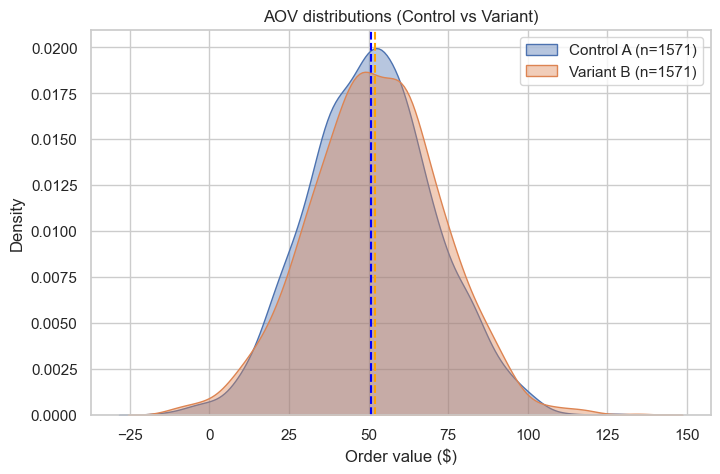

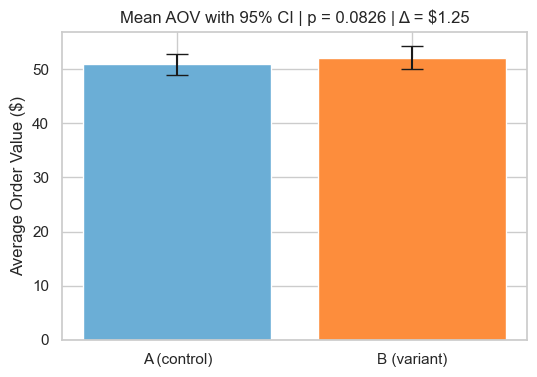

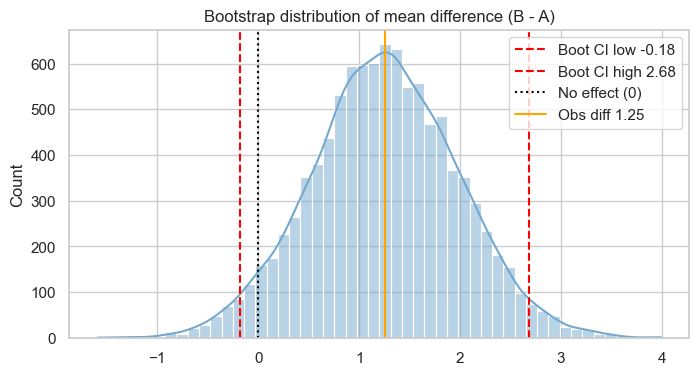

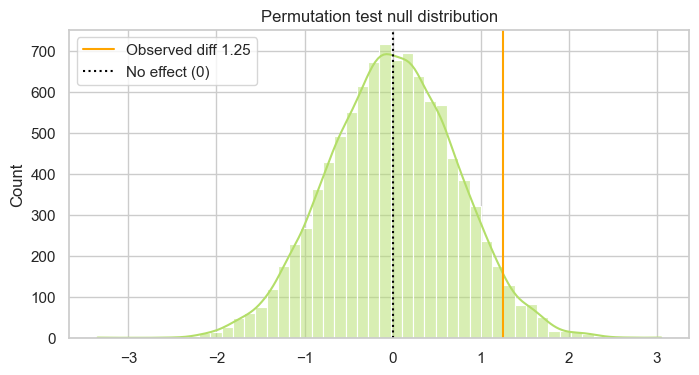

In [1]:
"""
A/B testing pipeline for AOV (Average Order Value)
Requirements:
    pip install numpy pandas matplotlib seaborn scipy statsmodels
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.weightstats import CompareMeans, DescrStatsW

sns.set(style="whitegrid")

# -------------------------
# Sample size calculation
# -------------------------
def required_sample_size_for_mean(delta, sigma, alpha=0.05, power=0.8, alternative='two-sided'):
    """
    Compute required sample size per group to detect absolute difference delta
    given std deviation sigma, alpha and desired power using Cohen's d.
    """
    d = delta / sigma
    analysis = TTestIndPower()
    n = analysis.solve_power(effect_size=d, alpha=alpha, power=power, alternative=alternative)
    return int(np.ceil(n))

# -------------------------
# Balance check
# -------------------------
def check_balance(df, group_col='bucket', covariates=None):
    """
    Quick balance checks for covariates across buckets A/B.
    df: DataFrame with group_col and covariates
    returns: DataFrame of summary stats and t-tests for numeric covariates
    """
    groups = df[group_col].unique()
    assert len(groups) == 2, "Expect exactly two buckets"
    g0, g1 = groups
    summary = {}
    for c in covariates or []:
        if pd.api.types.is_numeric_dtype(df[c]):
            a = df[df[group_col]==g0][c].dropna()
            b = df[df[group_col]==g1][c].dropna()
            t, p = stats.ttest_ind(a, b, equal_var=False)
            summary[c] = {'mean_A': a.mean(), 'mean_B': b.mean(), 't': t, 'p': p}
        else:
            # categorical: show distribution
            tab = pd.crosstab(df[c], df[group_col], normalize='columns')
            summary[c] = tab.to_dict()
    return summary

# -------------------------
# Bootstrap mean-diff
# -------------------------
def bootstrap_mean_diff(data_A, data_B, n_boot=10000, ci=95, seed=42):
    rng = np.random.default_rng(seed)
    nA, nB = len(data_A), len(data_B)
    boot_diffs = rng.choice(data_B, size=(n_boot, nB), replace=True).mean(axis=1) - \
                 rng.choice(data_A, size=(n_boot, nA), replace=True).mean(axis=1)
    lower = np.percentile(boot_diffs, (100 - ci) / 2)
    upper = np.percentile(boot_diffs, 100 - (100 - ci) / 2)
    return lower, upper, boot_diffs.mean(), boot_diffs

# -------------------------
# Permutation test
# -------------------------
def permutation_test_mean_diff(data_A, data_B, n_permutations=10000, seed=42):
    rng = np.random.default_rng(seed)
    observed = np.mean(data_B) - np.mean(data_A)
    combined = np.concatenate([data_A, data_B])
    nA = len(data_A)
    perm_diffs = np.empty(n_permutations)
    for i in range(n_permutations):
        rng.shuffle(combined)
        perm_A = combined[:nA]
        perm_B = combined[nA:]
        perm_diffs[i] = perm_B.mean() - perm_A.mean()
    p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed))
    return observed, p_value, perm_diffs

# -------------------------
# Primary analysis function
# -------------------------
def analyze_ab(data_A, data_B, alpha=0.05, plot=True):
    """
    Run primary analyses: Welch's t-test, CI (Welch), Cohen's d, bootstrap CI, permutation test.
    Returns a dict with results and optionally plots figures.
    """
    res = {}
    nA, nB = len(data_A), len(data_B)
    res['nA'] = nA; res['nB'] = nB
    
    # Summary stats
    res['mean_A'] = data_A.mean(); res['sd_A'] = data_A.std(ddof=1)
    res['mean_B'] = data_B.mean(); res['sd_B'] = data_B.std(ddof=1)
    res['mean_diff'] = res['mean_B'] - res['mean_A']
    
    # Welch t-test
    tstat, pval = stats.ttest_ind(data_B, data_A, equal_var=False)
    res['tstat'] = tstat; res['pval'] = pval
    
    # Welch CI for difference using CompareMeans
    cm = CompareMeans(DescrStatsW(data_B), DescrStatsW(data_A))
    ci_low, ci_upp = cm.tconfint_diff(usevar='unequal')
    res['ci_low'] = ci_low; res['ci_upp'] = ci_upp
    
    # Cohen's d (pooled)
    pooled_sd = np.sqrt(((nA-1)*data_A.var(ddof=1) + (nB-1)*data_B.var(ddof=1)) / (nA + nB - 2))
    res['cohen_d'] = (res['mean_diff']) / pooled_sd if pooled_sd > 0 else np.nan
    
    # Bootstrap
    b_low, b_up, b_mean, b_samples = bootstrap_mean_diff(data_A, data_B)
    res['boot_ci'] = (b_low, b_up); res['boot_mean'] = b_mean
    
    # Permutation test
    obs, p_perm, perm = permutation_test_mean_diff(data_A, data_B)
    res['perm_p'] = p_perm; res['perm_obs'] = obs
    
    if plot:
        # Distribution plot
        plt.figure(figsize=(8,5))
        sns.kdeplot(data_A, label=f'Control A (n={nA})', fill=True, alpha=0.4)
        sns.kdeplot(data_B, label=f'Variant B (n={nB})', fill=True, alpha=0.4)
        plt.axvline(res['mean_A'], color='blue', linestyle='--')
        plt.axvline(res['mean_B'], color='orange', linestyle='--')
        plt.title('AOV distributions (Control vs Variant)')
        plt.xlabel('Order value ($)')
        plt.legend()
        plt.show()
        
        # Bar chart with CI
        means = [res['mean_A'], res['mean_B']]
        ci_means = []
        for arr in [data_A, data_B]:
            se = arr.std(ddof=1) / np.sqrt(len(arr))
            t_q = stats.t.ppf(1-0.025, df=len(arr)-1)
            ci_means.append((arr.mean()-t_q*se, arr.mean()+t_q*se))
        plt.figure(figsize=(6,4))
        plt.bar(['A (control)','B (variant)'], means, yerr=[(m-l) for (l,m) in ci_means],
                capsize=8, color=['#6baed6','#fd8d3c'])
        plt.ylabel('Average Order Value ($)')
        plt.title(f'Mean AOV with 95% CI | p = {res["pval"]:.4f} | Δ = ${res["mean_diff"]:.2f}')
        plt.show()
        
        # Bootstrap histogram
        plt.figure(figsize=(8,4))
        sns.histplot(b_samples, bins=50, kde=True, color="#74a9cf")
        plt.axvline(b_low, color='red', linestyle='--', label=f"Boot CI low {b_low:.2f}")
        plt.axvline(b_up, color='red', linestyle='--', label=f"Boot CI high {b_up:.2f}")
        plt.axvline(0, color='black', linestyle=':', label='No effect (0)')
        plt.axvline(res['mean_diff'], color='orange', linestyle='-', label=f"Obs diff {res['mean_diff']:.2f}")
        plt.title('Bootstrap distribution of mean difference (B - A)')
        plt.legend()
        plt.show()
        
        # Permutation null distribution
        plt.figure(figsize=(8,4))
        sns.histplot(perm, bins=50, kde=True, color="#b3de69")
        plt.axvline(obs, color='orange', label=f"Observed diff {obs:.2f}")
        plt.axvline(0, color='black', linestyle=':', label='No effect (0)')
        plt.title('Permutation test null distribution')
        plt.legend()
        plt.show()
        
    return res

# -------------------------
# Usage example (replace with your real data)
# -------------------------
if __name__ == "__main__":
    # Example: simulate or load real data arrays: data_A, data_B
    # Suppose we simulated earlier as in your script
    mu_A = 50.0; mu_B = 52.0; sigma = 20.0
    n = required_sample_size_for_mean(delta=2.0, sigma=sigma)
    np.random.seed(42)
    data_A = np.random.normal(mu_A, sigma, n)
    data_B = np.random.normal(mu_B, sigma*1.05, n)
    results = analyze_ab(data_A, data_B)


**8. Practical recommendations & pitfalls to avoid**
- Don’t peek: fixed-sample testing avoids inflated Type I error. If you must check early, use proper sequential methods.
- Unit-of-analysis must match randomization: randomize at the user-level if user-level interference is possible.
- Control for outliers: AOV often skewed — winsorize or use median/log transform OR bootstrap.
- Pre-specify subgroups: avoid data-snooping/multiple comparisons. If conducting many subgroup tests, correct for multiplicity.
- Check exposure logs: ensure the bucket assignment persisted and there was no contamination.
- Business significance vs statistical significance: a tiny statistically significant lift may be economically irrelevant.

**9. Decision rule (example)**
- If pval < 0.05 AND mean_diff >= commercial MDE (e.g., $2) → promote B to rollout.
- If pval < 0.05 but mean_diff < MDE → consider ROI; maybe run larger test or micro-experiment to validate.
- If pval >= 0.05 but mean_diff positive and CI close to MDE → consider increasing n (run longer).
- If mean_diff negative → reject B.

**10. Deliverables for stakeholders**
- One-slide summary: headline result, lift, p-value, CI, recommendation.
- Dashboard: bar + CI, bootstrap histogram, permutation plot.
- Appendix: balance checks, randomization logs, raw data export.



In [2]:
results

{'nA': 1571,
 'nB': 1571,
 'mean_A': np.float64(50.9040440942545),
 'sd_A': np.float64(19.82553818227007),
 'mean_B': np.float64(52.15892641746599),
 'sd_B': np.float64(20.670033377092494),
 'mean_diff': np.float64(1.2548823232114898),
 'tstat': np.float64(1.7366173851798885),
 'pval': np.float64(0.08255297245147157),
 'ci_low': np.float64(-0.1619376693689838),
 'ci_upp': np.float64(2.6717023157919777),
 'cohen_d': np.float64(0.06196280215630817),
 'boot_ci': (np.float64(-0.17688157949709207), np.float64(2.683388127711417)),
 'boot_mean': np.float64(1.2531043362753924),
 'perm_p': np.float64(0.0824),
 'perm_obs': np.float64(1.2548823232114898)}

**Interpretation**

- Direction: Strategy B produced a small positive lift (+$1.25) in average order value.

  
- Significance: Both parametric (t-test) and nonparametric (permutation) tests yield $\rho \approx$ 0.08, so you cannot reject the null hypothesis at $\alpha$ = 0.05.
- Uncertainty: Both the Welch and bootstrap confidence intervals cross 0 → the lift is not statistically reliable.
- Effect size: Cohen’s d $\approx$ 0.06 → tiny effect relative to noise (sd $\approx$ $20).


✅ One-line takeaway:

Strategy B shows a small but statistically inconclusive lift in Average Order Value (+$1.25, p ≈ 0.08). Recommend extending the test or increasing the sample size before rollout.

**Interpret results** <br>
- $p-value < \alpha$ (e.g., 0.05) and the CI for (B−A) does not contain 0 → reject $H_0$: there is evidence of a difference in AOV.
- Sign of mean difference tells which is higher (if mean_diff > 0 → B > A).
- Cohen’s d gives practical effect-size magnitude (0.2 small, 0.5 medium, 0.8 large).
- Check CI width: a narrow CI means a precise estimate; a wide CI means more data is needed.
- Check assumptions: heavy tails or outliers → consider robust stats (e.g., bootstrap CI, trimmed means, or permutation test).

## Robust/alternative approaches
- Bootstrap the difference: build an empirical CI for the mean difference if normality is questionable.
- Permutation test: nonparametric test of equality of means/distributions (good when assumptions fail).
- Transformations: if AOV is skewed (heavy right tail), consider log(AOV) as a metric or use median and a test for medians.
- Segmented analysis: test overall effect and check heterogeneity by segment (e.g., new vs returning users), but pre-specify to avoid multiple comparisons.

**Option 1: Increase Sample Size**<br>
Your p-value (0.08) is borderline. If you double your sample size (≈3,000 per group), the same effect (+$1.25) might reach significance because the test’s power increases.<br>
That will show how many more samples you need for 80% power given the observed effect.

In [3]:
# observed numbers (replace with your own)
mean_A = 50.9040440942545
mean_B = 52.15892641746599
sd_A   = 19.82553818227007
sd_B   = 20.670033377092494
nA = 1571
nB = 1571

# pooled sd
pooled_sd = (( (nA-1)*sd_A**2 + (nB-1)*sd_B**2 ) / (nA + nB - 2))**0.5

# Cohen's d
d = (mean_B - mean_A) / pooled_sd
print(pooled_sd, d)

20.25218807964668 0.06196280215630817


In [4]:
# 'cohen_d': np.float64(0.06196280215630817),
analysis = TTestIndPower()
required_n = analysis.solve_power(effect_size=0.062, alpha=0.05, power=0.8)
print(required_n)


4084.6549175305786


In [5]:
analysis = TTestIndPower()
required_n = analysis.solve_power(effect_size=0.062, alpha=0.05, power=0.9)
print(required_n)

5467.880110883899
